# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *Under construction*

In [8]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data $X=\{x_t\}_{t=0}^{T-1}$, where $x_t=\{x_{i, t}\}_{i=1}^n$ is a vector of variabels at time $t$.

In [30]:
# Class to be built
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def construct_uncorrelated_series(self):
        # Deep copying DataFrame and calculating covariance matrix
        df = self.df.copy(deep=True)
        array = df.to_numpy()
        cov = np.cov(array.T)

        # Calculating eigenvalues and vectors from covariance matrix
        eigen_vals, eigen_vecs = eig(cov)
        eigen_vals = np.diag(eigen_vals)
        
        # Calculating orthogonal disturbances with unit variance
        array[:, :] = array.dot(eigen_vecs.dot(inv(eigen_vals)**0.5))

        # Renaming columns
        df.columns = [f'e{i}' for i in range(len(df.columns))]

        # Returning orthogonal disturbances
        return df

In [10]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,
2004-03-25 00:00:00+01:00,17.060760,1216.948120,10.377870,18.962233,22.093435
2004-03-26 00:00:00+01:00,17.216919,1199.807983,10.389773,19.238768,22.526636
2004-03-29 00:00:00+02:00,17.255962,1216.948120,10.330265,19.712824,21.985130
2004-03-30 00:00:00+02:00,17.177881,1222.661499,10.246959,18.646194,21.660233
2004-03-31 00:00:00+02:00,17.568289,1199.807983,10.282661,18.804214,21.573589
...,...,...,...,...,...
2023-10-19 00:00:00+02:00,207.600006,8.216000,59.320000,115.400002,386.000000
2023-10-20 00:00:00+02:00,206.000000,7.920000,58.020000,115.750000,361.600006
2023-10-23 00:00:00+02:00,206.000000,7.884000,56.759998,114.199997,361.399994


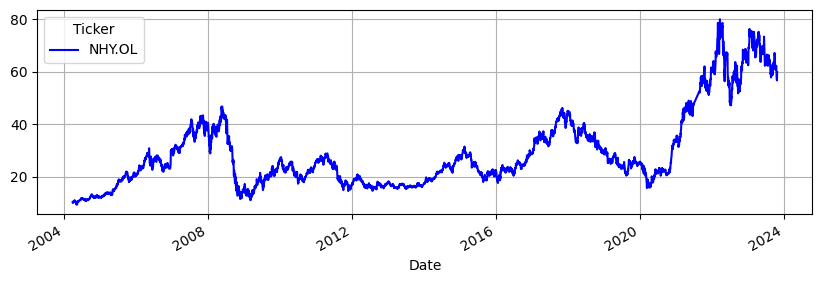

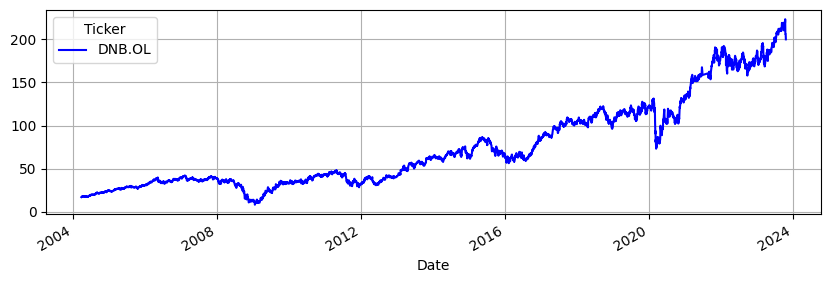

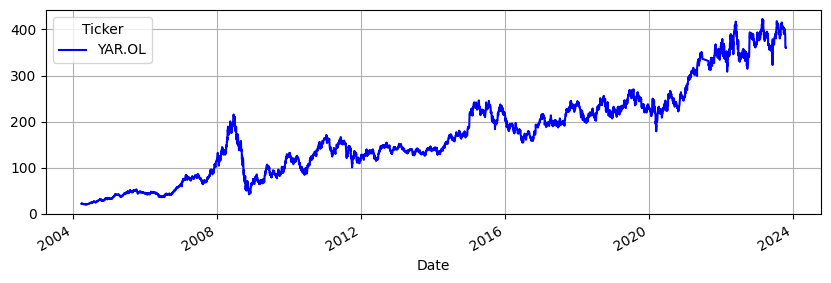

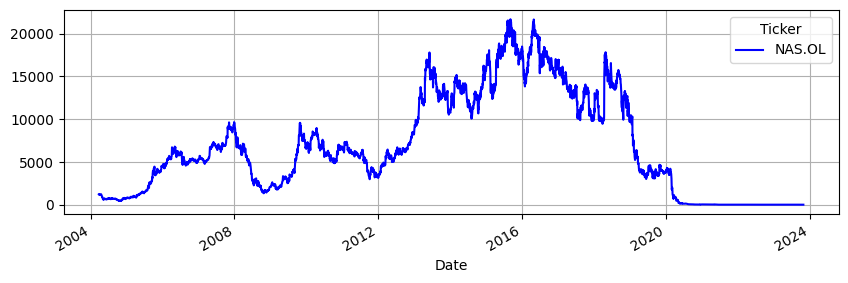

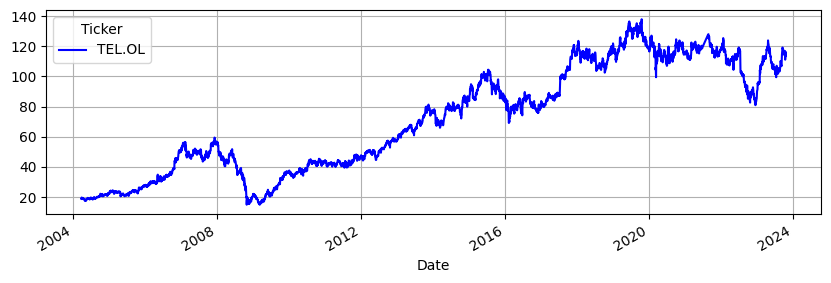

In [11]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [12]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,
2004-03-26 00:00:00+01:00,0.009111,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,0.004684,-0.008097,-0.055627,-0.014888
2004-03-31 00:00:00+02:00,0.022473,-0.018869,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,-0.014389,-0.005804,-0.004210,0.004008
...,...,...,...,...,...
2023-10-19 00:00:00+02:00,-0.072903,0.004880,-0.019697,0.037524,-0.004910
2023-10-20 00:00:00+02:00,-0.007737,-0.036692,-0.022159,0.003028,-0.065299
2023-10-23 00:00:00+02:00,0.000000,-0.004556,-0.021956,-0.013481,-0.000553


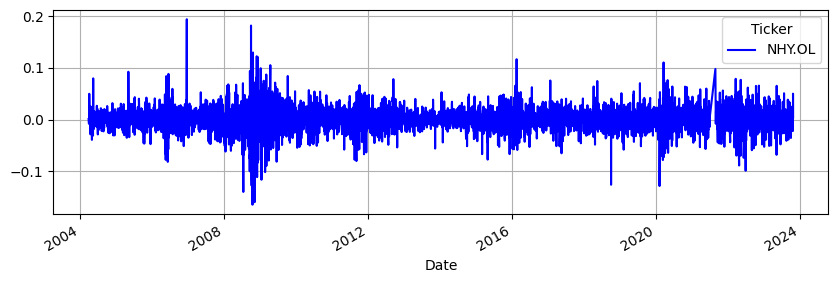

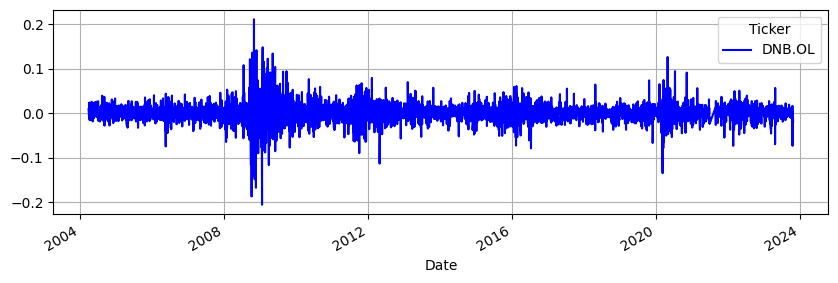

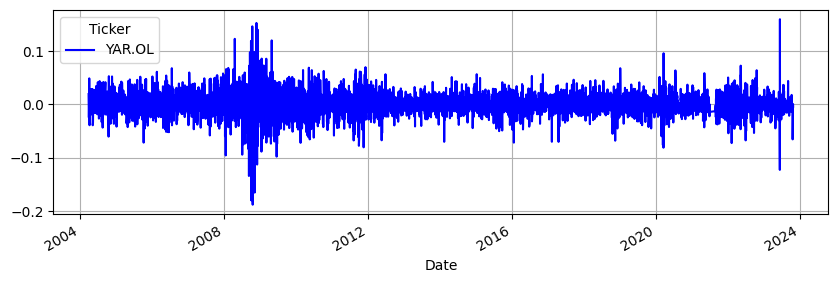

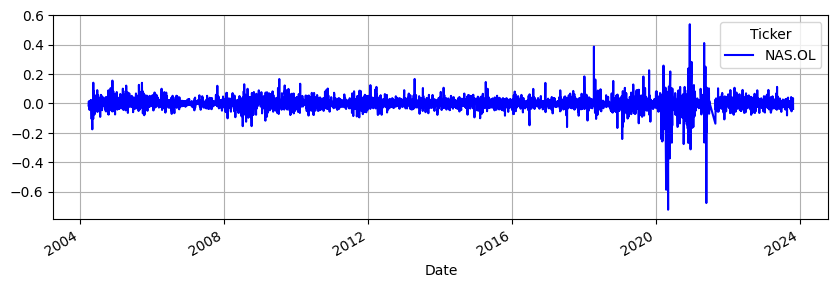

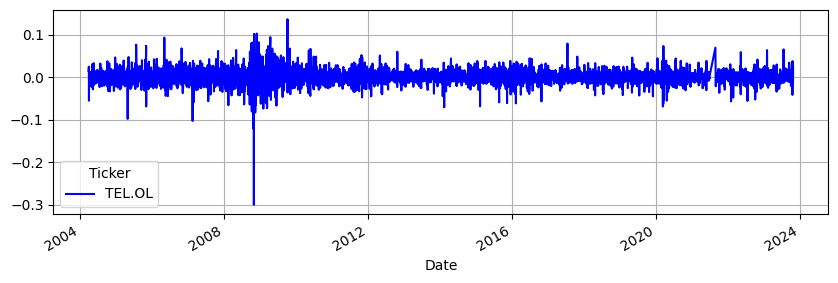

In [13]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [14]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,
DNB.OL,1.000000,0.194919,0.482621,0.388678,0.418201
NAS.OL,0.194919,1.000000,0.204136,0.152889,0.167211
NHY.OL,0.482621,0.204136,1.000000,0.353450,0.487615
TEL.OL,0.388678,0.152889,0.353450,1.000000,0.346832
YAR.OL,0.418201,0.167211,0.487615,0.346832,1.000000


In [15]:
models = {}
for ticker in tickers:
    models[ticker] = arch_model(df_diff[[ticker]], vol='garch', p=1, o=0, q=1, rescale=False)

In [16]:
fits = {key: val.fit() for key, val in models.items()}

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1752253102.7487867
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2728565167301.4023
Iteration:      3,   Func. Count:     31,   Neg. LLF: -11871.518231764834
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11871.518260685827
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.756057548235588e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: -12975.459490552503
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12975.459503296315
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 96060260.88177775
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6.494381881591039e+21
Iteration:      3,   Func. Count:     31,   Neg. LLF: -12214.253

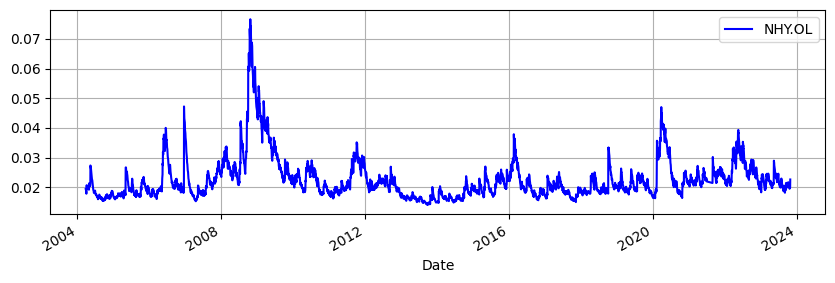

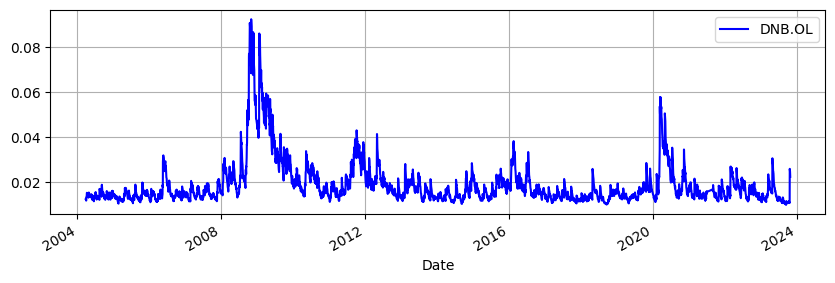

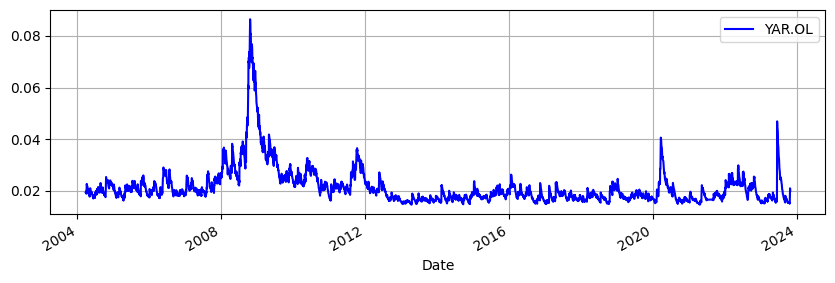

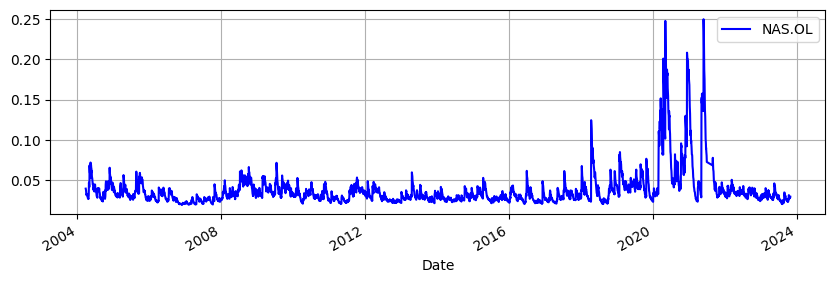

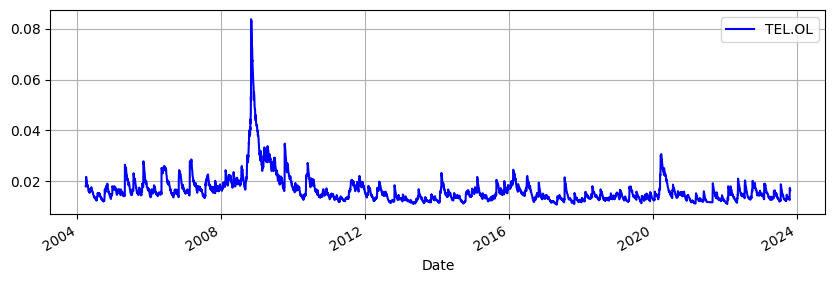

In [17]:
for ticker in tickers:
    pd.DataFrame({ticker: fits[ticker].conditional_volatility}).plot(color='b', figsize=(10, 3), grid=True)

In [34]:
model = MonteCarlo(df_diff)
df_e = model.construct_uncorrelated_series()

# Okay, the disturbances are orthogonal. This we can work with
df_e.cov().style.background_gradient(cmap='Blues')

,e0,e1,e2,e3,e4
e0,1.000000,-0.000000,0.000000,-0.000000,0.000000
e1,-0.000000,1.000000,-0.000000,0.000000,-0.000000
e2,0.000000,-0.000000,1.000000,0.000000,-0.000000
e3,-0.000000,0.000000,0.000000,1.000000,-0.000000
e4,0.000000,-0.000000,-0.000000,-0.000000,1.000000


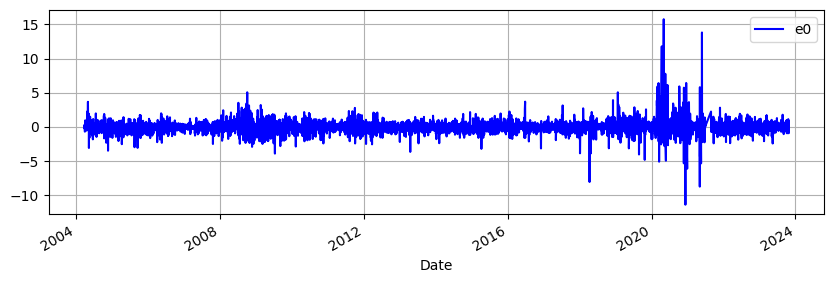

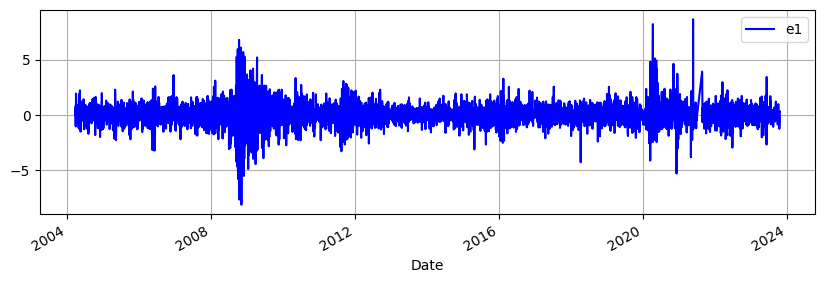

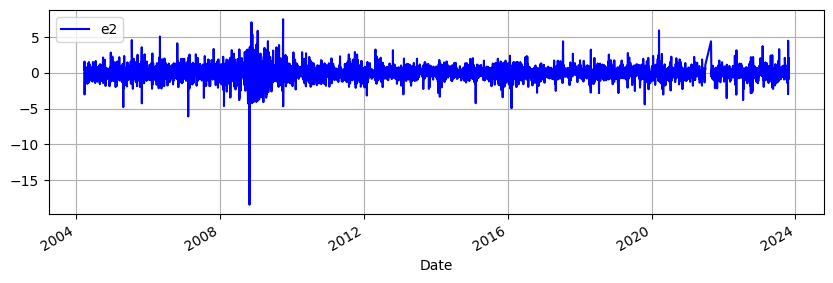

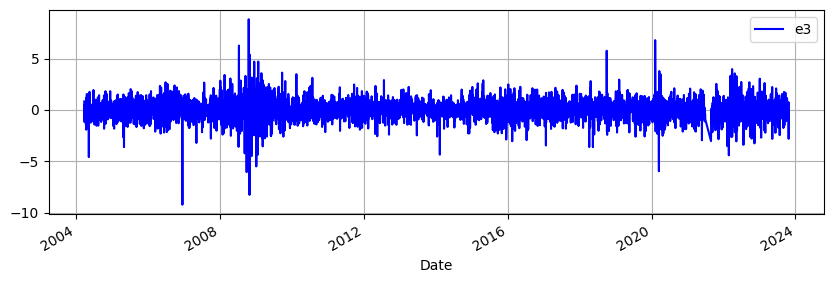

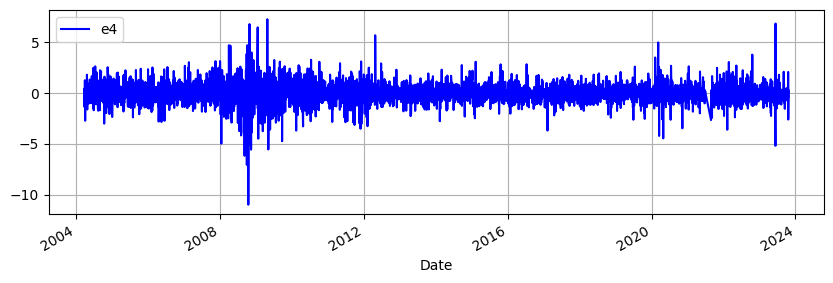

In [36]:
for col in df_e.columns:
    df_e[[col]].plot(color='b', figsize=(10, 3), grid=True)